In [4]:
import osmnx as ox
ox.__version__

'0.12.1'

In [5]:
ox.utils.config(all_oneway=True)

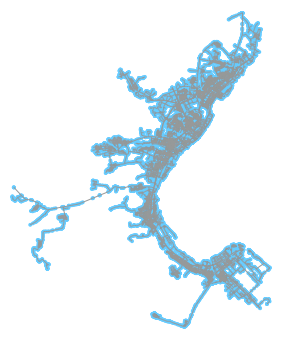

In [70]:
G = ox.graph_from_place('Volgograd', network_type='drive', simplify = False)
G = ox.project_graph(G)
fig, ax = ox.plot_graph(G)

In [71]:
len(G.nodes)

40657

In [72]:
len(G.edges)

45075

In [73]:
G_simp = ox.simplify.simplify_graph(G)

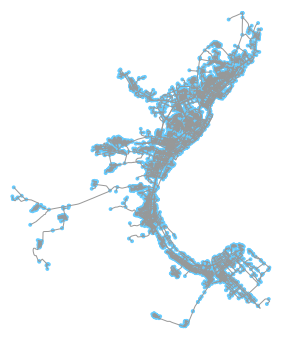

In [74]:
G_simp = ox.project_graph(G_simp)
fig, ax = ox.plot_graph(G_simp)

In [75]:
len(G_simp.nodes)

10200

In [76]:
len(G_simp.edges)

14618

In [77]:
ox.save_load.save_as_osm(G,node_tags=['highway'], node_attrs=['id', 'lat', 'lon'], edge_tags=['highway', 'lanes', 'maxspeed', 'oneway'], edge_attrs=['id'], oneway=False, merge_edges=True, edge_tag_aggs=None, filename='graph.osm', folder=None)

In [6]:
G_ox = ox.core.graph_from_file('graph.osm',  simplify=False, retain_all=True)

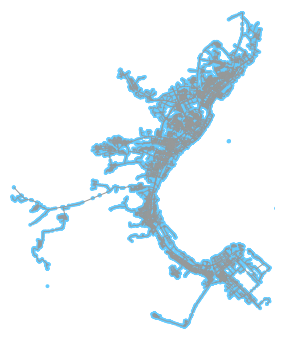

In [7]:
G_ox = ox.project_graph(G_ox)
fig, ax = ox.plot_graph(G_ox)

In [226]:
len(G_ox.nodes)

40767

In [227]:
len(G_ox.edges)

45075

In [219]:
print([node for node, data in G_ox.nodes(data=True)].count(5244338902))

1


In [228]:
nodes_id = [node for node in G_ox.nodes]

In [16]:
nodes_data = G_ox.nodes(data=True)

In [15]:
nodes_data[1688220386]

NameError: name 'nodes_data' is not defined

In [8]:
import networkx as nx

In [9]:
import csv
from lxml import etree as et
from random import choices, random

In [10]:
f = open('100houses.txt', 'r')
houses_id = f.readlines()
f.close()
f = open('10med.txt', 'r')
med_id = f.readlines()
f.close()
print(len(houses_id))
print(len(med_id))

100
10


In [11]:
#Добавим сначала то, что есть в графе, потом дополним

osm_file = 'graph.osm'
G = nx.DiGraph()
context = et.iterparse(osm_file, events=('end',), tag='node')
nodes = []
for event, elem in context:
    nodes.append(elem.get('id'))
    elem.clear()
    while elem.getprevious() is not None:
        del elem.getparent()[0]
del context
G.add_nodes_from(nodes)
for h in houses_id:
    G.nodes[h[:-1]]['building'] = 'house'
for m in med_id:
    G.nodes[m[:-1]]['building'] = 'hospital'
G.number_of_nodes()

40767

In [12]:
def distance(node1,node2):
    x1 = nodes_data[int(node1)]['x']
    y1 = nodes_data[int(node1)]['y']
    x2 = nodes_data[int(node2)]['x']
    y2 = nodes_data[int(node2)]['y']
    distance = ((x1-x2)**2 + (y1-y2)**2)**0.5
    return distance

In [17]:
context = et.iterparse(osm_file,events=('end',),tag='way')
edges = []
for event, elem in context:
    oneway = 0
    #Определим свойства
    for child in elem.iterchildren('tag'):
        key = child.get('k')      
        #Возможно, дорога односторонняя
        if key == 'oneway' and child.get('v') == 'yes':
            oneway = 1
    #Узнаем, какие вершины состоят в пути
    nodes_list = []
    for child in elem.iterchildren('nd'):
        _id = child.get('ref')
        nodes_list.append(child.get('ref'))
    #Добавляем ребра с весами в список смежности
    if oneway == 1:
        for i in range(len(nodes_list)-1):
            #Добавляем вершины
            from_node, to_node = nodes_list[i:i+2]
            d = distance(from_node, to_node)
            edges.append((from_node, to_node, {'weight': d}))
    else:
        for i in range(len(nodes_list)-1):
            from_node, to_node = nodes_list[i:i+2]
            d = distance(from_node, to_node)
            edges.append((from_node, to_node, {'weight': d}))
            edges.append((to_node, from_node, {'weight': d}))
    elem.clear()
    while elem.getprevious() is not None:
        del elem.getparent()[0]
del context

G.add_edges_from(edges)
G.number_of_edges()

85096

In [18]:
nodes_id = [node for node in G_ox.nodes]
nodes_data = G_ox.nodes(data=True)

In [19]:
#Добавим ребра к домам и больницам
nearest_nodes_id = []
copy_id = nodes_id
for h_id in houses_id:
    nni = '' #nearest_node_id
    min_dist = float('inf')
    while copy_id.count(h_id) > 0:
        copy_id.remove(h_id)
    for node_id in copy_id:
        d = distance(h_id,node_id)
        if d < min_dist:
            min_dist = d
            nni = node_id
    w = 1 + random()
    nearest_nodes_id.append((nni, h_id, {'weight': min_dist*w}))
    nearest_nodes_id.append((h_id, nni, {'weight': min_dist*w}))
        

copy_id = nodes_id   
for m_id in med_id:
    nni = '' #nearest_node_id
    min_dist = float('inf')
    while copy_id.count(m_id) > 0:
        copy_id.remove(m_id)
    for node_id in copy_id:
        d = distance(m_id,node_id)
        if d < min_dist:
            min_dist = d
            nni = node_id
    w = 1 + random()
    nearest_nodes_id.append((nni, m_id, {'weight': min_dist*w}))
    nearest_nodes_id.append((m_id, nni, {'weight': min_dist*w}))
len(nearest_nodes_id)

220

In [20]:
G.add_edges_from(nearest_nodes_id)

G.number_of_edges()

85316

In [306]:
#Создадим список смежности
nx.readwrite.adjlist.write_adjlist(G,'adj_list.csv')

In [325]:
with open('adj_list2.csv','w',newline='') as csv_file:
    csv_file.write('from_id to_id,edge_weight\n')
    for _from in list(G.nodes):
        s = str(_from)
        for _to in G.successors(_from):
            s = s + ' ' + str(_to) + ',' + str(G[_from][_to]['weight'])
        csv_file.write(s + '\n')


In [ ]:
#nx.linalg.graphmatrix.adjacency_matrix(G)

In [307]:
#Создадим матрицу смежности
adj_matrix = nx.to_pandas_adjacency(G)
adj_matrix.to_csv('adj_matrix.csv')

In [322]:
print(adj_matrix)

              1688220386  5244338893  5244338894  5244338895  5244338896  \
1688220386           0.0         0.0    0.000000    0.000000    0.000000   
5244338893           0.0         0.0    4.494962    0.000000    0.000000   
5244338894           0.0         0.0    0.000000    5.460534    0.000000   
5244338895           0.0         0.0    0.000000    0.000000    4.494962   
5244338896           0.0         0.0    0.000000    0.000000    0.000000   
...                  ...         ...         ...         ...         ...   
4150483689\n         0.0         0.0    0.000000    0.000000    0.000000   
1252259775           0.0         0.0    0.000000    0.000000    0.000000   
1252259775\n         0.0         0.0    0.000000    0.000000    0.000000   
4649529194           0.0         0.0    0.000000    0.000000    0.000000   
4649529194\n         0.0         0.0    0.000000    0.000000    0.000000   

              5244338897  5244338898  1155399734  5244338899  1688220397  ...  \
168822

In [324]:
matrix = adj_matrix.values
print(matrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         4.49496201 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [266]:
class MinNodeHeap:

    def __init__(self,g={}):
        self.heap = []
        self.size = 0
        self.g = g

    def left_index(self,i):
        return 2*i+1

    def right_index(self,i):
        return 2*i+2

    def parent_index(self,i):
        return (i-1)//2

    def min_heapify(self,i):
        l = self.left_index(i)
        r = self.right_index(i)

        if l < self.size and self.g[self.heap[l]]['weight'] < self.g[self.heap[i]]['weight']:
            smallest = l
        else:
            smallest = i
        if r < self.size and self.g[self.heap[r]]['weight'] < self.g[self.heap[smallest]]['weight']:
            smallest = r
        if smallest != i:
            self.heap[i], self.heap[smallest] = self.heap[smallest], self.heap[i]
            self.min_heapify(smallest)
            

    def build_min_heap(self,_list):
        self.heap = _list
        self.size = len(_list)
        for i in range(len(_list)//2,-1,-1):
            self.min_heapify(i)
            
    def extract_min(self):
        if self.size < 1:
            return None
        _min = self.heap[0]
        self.heap[0] = self.heap[self.size-1]
        self.size -= 1
        self.min_heapify(0)
        return _min


In [274]:
def initialize_single_sourse(G,_from):
    g = {}
    for v_id in list(G.nodes):
        g[v_id] = {'way': [], 'weight':float('inf')}
    g[_from] = {'way':[_from], 'weight':0}
    return g

def relax(G,g,_from,_to):
    if g[_to]['weight'] > g[_from]['weight'] + G[_from][_to]['weight']:
        g[_to]['weight'] = g[_from]['weight'] + G[_from][_to]['weight']
        g[_to]['way'] = (g[_from]['way']).copy()
        g[_to]['way'].append(_to)
        
def dijkstra(G,_from,to_list):
    g = initialize_single_sourse(G,_from)
    finish = 0
    nodes = MinNodeHeap(g)
    nodes.build_min_heap(list(G.nodes))
    while nodes.size > 0 and finish < len(to_list):
        u = nodes.extract_min()
        if to_list.count(u) > 0:
            finish += 1
        for v in G.successors(u):
            relax(G,g,u,v)
    return g


In [271]:
ok = nx.DiGraph()
ok.add_nodes_from(['2', '1', '3', '4', '5'])
to_list = ['2','3']
ok.add_edges_from([('1','2', {'weight': 1}), ('1','3', {'weight': 2}), ('1','4', {'weight': 5}), ('4','5', {'weight': 3})])

In [272]:
g = initialize_single_sourse(ok, '1')
nodes = MinNodeHeap(g)
finish = 0
nodes.build_min_heap(list(ok.nodes))
while nodes.size > 0 and finish < len(to_list):
        u = nodes.extract_min()
        if to_list.count(u) > 0:
            finish += 1
        for v in ok.successors(u):
            relax(ok,g,u,v)  
g

{'2': {'way': ['1', '2'], 'weight': 1},
 '1': {'way': ['1'], 'weight': 0},
 '3': {'way': ['1', '3'], 'weight': 2},
 '4': {'way': ['1', '4'], 'weight': 5},
 '5': {'way': [], 'weight': inf}}

In [275]:
dijkstra(ok,'1',['2','3'])

{'2': {'way': ['1', '2'], 'weight': 1},
 '1': {'way': ['1'], 'weight': 0},
 '3': {'way': ['1', '3'], 'weight': 2},
 '4': {'way': ['1', '4'], 'weight': 5},
 '5': {'way': [], 'weight': inf}}

In [253]:
list(G.nodes).count('3239852539') + list(G.nodes).count('4682991839')

2

In [278]:
dijkstra(G,'5244338893',['5244338894'])

{'way': [], 'weight': inf}

In [279]:
a = dijkstra(G,'3239852539',['4682991839'])
a['4682991839']

{'way': [], 'weight': inf}